In [1]:
from __future__ import division
import gym
import numpy as np
import random
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
import tf_slim as slim

In [2]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

Instructions for updating:
non-resource variables are not supported in the long term


In [3]:
env = gym.make('CartPole-v0')

In [4]:
class experience_buffer():
    def __init__(self, buffer_size = 10000):
        self.buffer = []
        self.buffer_size = buffer_size
    
    def add(self,experience):
        if len(self.buffer) + len(experience) >= self.buffer_size:
            self.buffer[0:(len(experience)+len(self.buffer))-self.buffer_size] = []
        self.buffer.extend(experience)
            
    def sample(self,size):
        return np.reshape(np.array(random.sample(self.buffer,size)),[size,5])
    
def updateTargetGraph(tfVars,tau):
    total_vars = len(tfVars)
    op_holder = []
    for idx,var in enumerate(tfVars[0:total_vars//2]):
        op_holder.append(tfVars[idx+total_vars//2].assign((var.value()*tau) + ((1-tau)*tfVars[idx+total_vars//2].value())))
    return op_holder

def updateTarget(op_holder,sess):
    for op in op_holder:
        sess.run(op)

In [5]:
class Q_Network():
    def __init__(self):
        #These lines establish the feed-forward part of the network used to choose actions
        self.inputs = tf.compat.v1.placeholder(shape=[None,4],dtype=tf.float32)
        self.Temp = tf.compat.v1.placeholder(shape=None,dtype=tf.float32)
        self.keep_per = tf.compat.v1.placeholder(shape=None,dtype=tf.float32)

        hidden = slim.fully_connected(self.inputs,64,activation_fn=tf.nn.tanh,biases_initializer=None)
        hidden = slim.dropout(hidden,self.keep_per)
        self.Q_out = slim.fully_connected(hidden,2,activation_fn=None,biases_initializer=None)
        
        self.predict = tf.argmax(self.Q_out,1)
        self.Q_dist = tf.nn.softmax(self.Q_out/self.Temp)
        
        
        #Below we obtain the loss by taking the sum of squares difference between the target and prediction Q values.
        self.actions = tf.compat.v1.placeholder(shape=[None],dtype=tf.int32)
        self.actions_onehot = tf.one_hot(self.actions,2,dtype=tf.float32)
        
        self.Q = tf.reduce_sum(tf.multiply(self.Q_out, self.actions_onehot), reduction_indices=1)
        
        self.nextQ = tf.compat.v1.placeholder(shape=[None],dtype=tf.float32)
        loss = tf.reduce_sum(tf.square(self.nextQ - self.Q))
        trainer = tf.train.GradientDescentOptimizer(learning_rate=0.0005)
        self.updateModel = trainer.minimize(loss)

In [12]:
# Set learning parameters
exploration = "e-greedy" #Exploration method. Choose between: greedy, random, e-greedy, boltzmann, bayesian.
y = .99 #Discount factor.
num_episodes = 20000 #Total number of episodes to train network for.
tau = 0.001 #Amount to update target network at each step.
batch_size = 32 #Size of training batch
startE = 1 #Starting chance of random action
endE = 0.1 #Final chance of random action
anneling_steps = 200000 #How many steps of training to reduce startE to endE.
pre_train_steps = 50000 #Number of steps used before training updates begin.

In [13]:
def choice(exploration):
    tf.compat.v1.reset_default_graph()

    q_net = Q_Network()
    target_net = Q_Network()

    init = tf.initialize_all_variables()
    trainables = tf.trainable_variables()
    targetOps = updateTargetGraph(trainables,tau)
    myBuffer = experience_buffer()


    #create lists to contain total rewards and steps per episode
    jList = []
    jMeans = []
    rList = []
    rMeans = []
    with tf.Session() as sess:
        sess.run(init)
        updateTarget(targetOps,sess)
        e = startE
        stepDrop = (startE - endE)/anneling_steps
        total_steps = 0

        for i in range(num_episodes):
            s = env.reset()
            rAll = 0
            d = False
            j = 0
            while j < 999:
                j+=1
                if exploration == "greedy":
                    #Choose an action with the maximum expected value.
                    a,allQ = sess.run([q_net.predict,q_net.Q_out],feed_dict={q_net.inputs:[s],q_net.keep_per:1.0})
                    a = a[0]
                if exploration == "random":
                    #Choose an action randomly.
                    a = env.action_space.sample()
                if exploration == "e-greedy":
                    #Choose an action by greedily (with e chance of random action) from the Q-network
                    if np.random.rand(1) < e or total_steps < pre_train_steps:
                        a = env.action_space.sample()
                    else:
                        a,allQ = sess.run([q_net.predict,q_net.Q_out],feed_dict={q_net.inputs:[s],q_net.keep_per:1.0})
                        a = a[0]
                if exploration == "boltzmann":
                    #Choose an action probabilistically, with weights relative to the Q-values.
                    Q_d,allQ = sess.run([q_net.Q_dist,q_net.Q_out],feed_dict={q_net.inputs:[s],q_net.Temp:e,q_net.keep_per:1.0})
                    a = np.random.choice(Q_d[0],p=Q_d[0])
                    a = np.argmax(Q_d[0] == a)
                if exploration == "bayesian":
                    #Choose an action using a sample from a dropout approximation of a bayesian q-network.
                    a,allQ = sess.run([q_net.predict,q_net.Q_out],feed_dict={q_net.inputs:[s],q_net.keep_per:(1-e)+0.1})
                    a = a[0]

                #Get new state and reward from environment
                s1,r,d,_ = env.step(a)
                myBuffer.add(np.reshape(np.array([s,a,r,s1,d]),[1,5]))

                if e > endE and total_steps > pre_train_steps:
                    e -= stepDrop

                if total_steps > pre_train_steps and total_steps % 5 == 0:
                    #We use Double-DQN training algorithm
                    trainBatch = myBuffer.sample(batch_size)
                    Q1 = sess.run(q_net.predict,feed_dict={q_net.inputs:np.vstack(trainBatch[:,3]),q_net.keep_per:1.0})
                    Q2 = sess.run(target_net.Q_out,feed_dict={target_net.inputs:np.vstack(trainBatch[:,3]),target_net.keep_per:1.0})
                    end_multiplier = -(trainBatch[:,4] - 1)
                    doubleQ = Q2[range(batch_size),Q1]
                    targetQ = trainBatch[:,2] + (y*doubleQ * end_multiplier)
                    _ = sess.run(q_net.updateModel,feed_dict={q_net.inputs:np.vstack(trainBatch[:,0]),q_net.nextQ:targetQ,q_net.keep_per:1.0,q_net.actions:trainBatch[:,1]})
                    updateTarget(targetOps,sess)

                rAll += r
                s = s1
                total_steps += 1
                if d == True:
                    break
            jList.append(j)
            rList.append(rAll)
            if i % 100 == 0 and i != 0:
                r_mean = np.mean(rList[-100:])
                j_mean = np.mean(jList[-100:])
                if exploration == 'e-greedy':
                    print("Mean Reward: " + str(r_mean) + " Total Steps: " + str(total_steps) + " e: " + str(e))
                if exploration == 'boltzmann':
                    print("Mean Reward: " + str(r_mean) + " Total Steps: " + str(total_steps) + " t: " + str(e))
                if exploration == 'bayesian':
                    print("Mean Reward: " + str(r_mean) + " Total Steps: " + str(total_steps) + " p: " + str(e))
                if exploration == 'random' or exploration == 'greedy':
                    print("Mean Reward: " + str(r_mean) + " Total Steps: " + str(total_steps))
                rMeans.append(r_mean)
                jMeans.append(j_mean)
    print("Percent of succesful episodes: " + str(sum(rList)/num_episodes) + "%")
    return(rMeans, jMeans)

In [14]:
greedy_rmeans, greedy_jmeans = choice("greedy")
e_greedy_rmeans, e_greedy_jmeans = choice("e-greedy")
random_rmeans, random_jmeans = choice("random")
boltzmann_rmeans, boltzmann_jmeans = choice("boltzmann")
bayesian_rmeans, bayesian_jmeans = choice("bayesian")
#Exploration method. Choose between: greedy, random, e-greedy, boltzmann, bayesian.


#plt.plot(rMeans)

C:\Users\hp\AppData\Local\Temp/ipykernel_28204/3931107228.py:58: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  myBuffer.add(np.reshape(np.array([s,a,r,s1,d]),[1,5]))


Mean Reward: 200.0 Total Steps: 20200
Mean Reward: 200.0 Total Steps: 40200
Mean Reward: 164.19 Total Steps: 56619
Mean Reward: 111.79 Total Steps: 67798
Mean Reward: 100.43 Total Steps: 77841
Mean Reward: 96.47 Total Steps: 87488
Mean Reward: 85.42 Total Steps: 96030
Mean Reward: 75.6 Total Steps: 103590
Mean Reward: 82.24 Total Steps: 111814
Mean Reward: 78.39 Total Steps: 119653
Mean Reward: 88.8 Total Steps: 128533
Mean Reward: 89.55 Total Steps: 137488
Mean Reward: 90.58 Total Steps: 146546
Mean Reward: 92.74 Total Steps: 155820
Mean Reward: 100.45 Total Steps: 165865
Mean Reward: 105.39 Total Steps: 176404
Mean Reward: 107.67 Total Steps: 187171
Mean Reward: 104.38 Total Steps: 197609
Mean Reward: 113.15 Total Steps: 208924
Mean Reward: 115.0 Total Steps: 220424
Mean Reward: 112.23 Total Steps: 231647
Mean Reward: 113.47 Total Steps: 242994
Mean Reward: 115.33 Total Steps: 254527
Mean Reward: 114.37 Total Steps: 265964
Mean Reward: 128.43 Total Steps: 278807
Mean Reward: 123.6 To

Mean Reward: 22.84 Total Steps: 8996 e: 1
Mean Reward: 22.32 Total Steps: 11228 e: 1
Mean Reward: 22.49 Total Steps: 13477 e: 1
Mean Reward: 21.88 Total Steps: 15665 e: 1
Mean Reward: 22.79 Total Steps: 17944 e: 1
Mean Reward: 23.99 Total Steps: 20343 e: 1
Mean Reward: 22.51 Total Steps: 22594 e: 1
Mean Reward: 21.83 Total Steps: 24777 e: 1
Mean Reward: 23.7 Total Steps: 27147 e: 1
Mean Reward: 22.87 Total Steps: 29434 e: 1
Mean Reward: 21.42 Total Steps: 31576 e: 1
Mean Reward: 19.78 Total Steps: 33554 e: 1
Mean Reward: 22.45 Total Steps: 35799 e: 1
Mean Reward: 22.13 Total Steps: 38012 e: 1
Mean Reward: 23.06 Total Steps: 40318 e: 1
Mean Reward: 23.7 Total Steps: 42688 e: 1
Mean Reward: 22.28 Total Steps: 44916 e: 1
Mean Reward: 20.69 Total Steps: 46985 e: 1
Mean Reward: 21.64 Total Steps: 49149 e: 1
Mean Reward: 21.48 Total Steps: 51297 e: 0.9941680000000481
Mean Reward: 20.48 Total Steps: 53345 e: 0.9849520000001242
Mean Reward: 21.26 Total Steps: 55471 e: 0.9753850000002031
Mean R

Mean Reward: 9.97 Total Steps: 218277 e: 0.24275800000311998
Mean Reward: 10.26 Total Steps: 219303 e: 0.2381410000031296
Mean Reward: 10.31 Total Steps: 220334 e: 0.23350150000313927
Mean Reward: 10.16 Total Steps: 221350 e: 0.2289295000031488
Mean Reward: 10.32 Total Steps: 222382 e: 0.22428550000315847
Mean Reward: 10.25 Total Steps: 223407 e: 0.21967300000316808
Mean Reward: 10.23 Total Steps: 224430 e: 0.21506950000317768
Mean Reward: 10.05 Total Steps: 225435 e: 0.2105470000031871
Mean Reward: 9.98 Total Steps: 226433 e: 0.20605600000319646
Mean Reward: 10.18 Total Steps: 227451 e: 0.201475000003206
Mean Reward: 10.06 Total Steps: 228457 e: 0.19694800000321544
Mean Reward: 10.07 Total Steps: 229464 e: 0.19241650000322488
Mean Reward: 9.99 Total Steps: 230463 e: 0.18792100000323425
Mean Reward: 9.94 Total Steps: 231457 e: 0.18344800000324357
Mean Reward: 9.87 Total Steps: 232444 e: 0.17900650000325283
Mean Reward: 9.85 Total Steps: 233429 e: 0.17457400000326206
Mean Reward: 9.76 T

Mean Reward: 23.6 Total Steps: 278925
Mean Reward: 22.83 Total Steps: 281208
Mean Reward: 21.48 Total Steps: 283356
Mean Reward: 20.4 Total Steps: 285396
Mean Reward: 22.26 Total Steps: 287622
Mean Reward: 23.65 Total Steps: 289987
Mean Reward: 21.31 Total Steps: 292118
Mean Reward: 21.74 Total Steps: 294292
Mean Reward: 22.87 Total Steps: 296579
Mean Reward: 24.22 Total Steps: 299001
Mean Reward: 19.96 Total Steps: 300997
Mean Reward: 21.68 Total Steps: 303165
Mean Reward: 22.54 Total Steps: 305419
Mean Reward: 20.81 Total Steps: 307500
Mean Reward: 21.59 Total Steps: 309659
Mean Reward: 22.34 Total Steps: 311893
Mean Reward: 24.42 Total Steps: 314335
Mean Reward: 22.89 Total Steps: 316624
Mean Reward: 22.46 Total Steps: 318870
Mean Reward: 23.11 Total Steps: 321181
Mean Reward: 23.37 Total Steps: 323518
Mean Reward: 22.04 Total Steps: 325722
Mean Reward: 22.64 Total Steps: 327986
Mean Reward: 23.18 Total Steps: 330304
Mean Reward: 22.63 Total Steps: 332567
Mean Reward: 23.24 Total St

Mean Reward: 9.42 Total Steps: 121665 t: 0.6775120000026611
Mean Reward: 9.41 Total Steps: 122606 t: 0.673277500002696
Mean Reward: 9.52 Total Steps: 123558 t: 0.6689935000027314
Mean Reward: 9.38 Total Steps: 124496 t: 0.6647725000027662
Mean Reward: 9.51 Total Steps: 125447 t: 0.6604930000028015
Mean Reward: 9.43 Total Steps: 126390 t: 0.6562495000028365
Mean Reward: 9.47 Total Steps: 127337 t: 0.6519880000028717
Mean Reward: 9.39 Total Steps: 128276 t: 0.6477625000029066
Mean Reward: 9.51 Total Steps: 129227 t: 0.6434830000029419
Mean Reward: 9.38 Total Steps: 130165 t: 0.6392620000029767
Mean Reward: 9.47 Total Steps: 131112 t: 0.6350005000030119
Mean Reward: 9.5 Total Steps: 132062 t: 0.6307255000030472
Mean Reward: 9.39 Total Steps: 133001 t: 0.626500000003082
Mean Reward: 9.46 Total Steps: 133947 t: 0.6222430000031172
Mean Reward: 9.39 Total Steps: 134886 t: 0.618017500003152
Mean Reward: 9.48 Total Steps: 135834 t: 0.6137515000031872
Mean Reward: 9.43 Total Steps: 136777 t: 0.6

Mean Reward: 12.69 Total Steps: 80076 p: 0.8646625000011168
Mean Reward: 13.88 Total Steps: 81464 p: 0.8584165000011683
Mean Reward: 14.96 Total Steps: 82960 p: 0.8516845000012239
Mean Reward: 14.5 Total Steps: 84410 p: 0.8451595000012777
Mean Reward: 15.8 Total Steps: 85990 p: 0.8380495000013364
Mean Reward: 17.5 Total Steps: 87740 p: 0.8301745000014014
Mean Reward: 18.51 Total Steps: 89591 p: 0.8218450000014701
Mean Reward: 19.36 Total Steps: 91527 p: 0.813133000001542
Mean Reward: 18.39 Total Steps: 93366 p: 0.8048575000016103
Mean Reward: 18.33 Total Steps: 95199 p: 0.7966090000016783
Mean Reward: 22.93 Total Steps: 97492 p: 0.7862905000017635
Mean Reward: 25.98 Total Steps: 100090 p: 0.77459950000186
Mean Reward: 23.87 Total Steps: 102477 p: 0.7638580000019486
Mean Reward: 23.86 Total Steps: 104863 p: 0.7531210000020372
Mean Reward: 25.95 Total Steps: 107458 p: 0.7414435000021335
Mean Reward: 27.52 Total Steps: 110210 p: 0.7290595000022357
Mean Reward: 24.01 Total Steps: 112611 p:

Mean Reward: 172.71 Total Steps: 1586809 p: 0.09999550000334036
Mean Reward: 170.16 Total Steps: 1603825 p: 0.09999550000334036
Mean Reward: 176.91 Total Steps: 1621516 p: 0.09999550000334036
Mean Reward: 170.65 Total Steps: 1638581 p: 0.09999550000334036
Mean Reward: 162.47 Total Steps: 1654828 p: 0.09999550000334036
Mean Reward: 176.93 Total Steps: 1672521 p: 0.09999550000334036
Mean Reward: 177.97 Total Steps: 1690318 p: 0.09999550000334036
Mean Reward: 173.49 Total Steps: 1707667 p: 0.09999550000334036
Mean Reward: 173.25 Total Steps: 1724992 p: 0.09999550000334036
Mean Reward: 172.29 Total Steps: 1742221 p: 0.09999550000334036
Mean Reward: 178.3 Total Steps: 1760051 p: 0.09999550000334036
Mean Reward: 171.75 Total Steps: 1777226 p: 0.09999550000334036
Mean Reward: 175.84 Total Steps: 1794810 p: 0.09999550000334036
Mean Reward: 181.55 Total Steps: 1812965 p: 0.09999550000334036
Mean Reward: 174.98 Total Steps: 1830463 p: 0.09999550000334036
Mean Reward: 182.36 Total Steps: 1848699 

Text(0.5, 0, 'Time Steps')

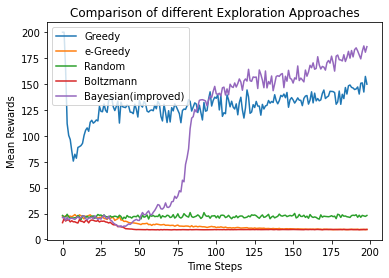

In [17]:
plt.plot(greedy_rmeans)
plt.plot(e_greedy_rmeans)
plt.plot(random_rmeans)
plt.plot(boltzmann_rmeans)
plt.plot(bayesian_rmeans)
plt.legend(['Greedy', 'e-Greedy', 'Random', 'Boltzmann', 'Bayesian(improved)'], loc='upper left')
plt.title('Comparison of different Exploration Approaches')
plt.ylabel('Mean Rewards')
plt.xlabel('Time Steps')